<a href="https://colab.research.google.com/github/somilvasal/Covid-AI/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing necessary libraries

In [34]:
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50, InceptionV3, Xception
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sn
import pandas as pd
import numpy as np
import random
import shutil
import time
import os
print('Library Importing Complete')

Library Importing Complete


# Loading data

In [ ]:
!git clone https://github.com/somilvasal/Covid-Data.git

Cloning into 'Covid-Data'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 7264 (delta 2), reused 0 (delta 0), pack-reused 7250
Receiving objects: 100% (7264/7264), 524.06 MiB | 20.25 MiB/s, done.
Resolving deltas: 100% (5/5), done.


# Split data into Training / Validation / Testing set



In [ ]:
# Clear existing dir
try:
  shutil.rmtree('/content/data')
except:
  pass

# Creating data dir
os.mkdir('/content/data')

os.mkdir('/content/data/train')
os.mkdir('/content/data/val')
os.mkdir('/content/data/test')

os.mkdir('/content/data/train/covid')
os.mkdir('/content/data/train/normal')
os.mkdir('/content/data/train/pneumonia')

os.mkdir('/content/data/val/covid')
os.mkdir('/content/data/val/normal')
os.mkdir('/content/data/val/pneumonia')

os.mkdir('/content/data/test/covid')
os.mkdir('/content/data/test/normal')
os.mkdir('/content/data/test/pneumonia')

In [ ]:
# Split data into train, val and test set in ratio of 8:1:1
# And copy From '/content/Covid-Data' to '/content/data'

data_src = '/content/Covid-Data/data'
data_dst = '/content/data'

covid_img_paths     = os.listdir(os.path.join(data_src,'covid'))
normal_img_paths    = os.listdir(os.path.join(data_src,'normal'))
pneumonia_img_paths = os.listdir(os.path.join(data_src,'pneumonia'))

def copy_img(img_paths, data_dst, data_class):
  # split data
  total_len  = len(img_paths)
  train_size = int(total_len * 0.8)
  val_size   = int(total_len * 0.1)
  test_size  = int(total_len * 0.1)

  print('\nImages Split :', [train_size, val_size, test_size])
  start, end = 0, 0
  
  for data_size, sub_dir in zip([train_size, val_size, test_size], ['train', 'val', 'test']):    
    full_data_src = os.path.join(data_src, data_class)
    full_data_dst = os.path.join(os.path.join(data_dst, sub_dir), data_class)  
    start = end
    end += data_size
    for i in img_paths[start:end]:
      src = os.path.join(full_data_src, i)
      dst = os.path.join(full_data_dst, i)
      shutil.copy(src, dst)
    print(len(os.listdir(full_data_dst)),sub_dir,'Images at path', full_data_dst)

copy_img(covid_img_paths[:700], data_dst, 'covid')
copy_img(normal_img_paths[:2150], data_dst, 'normal')
copy_img(pneumonia_img_paths[:2150], data_dst, 'pneumonia')


Images Split : [560, 70, 70]
560 train Images at path /content/data/train/covid
70 val Images at path /content/data/val/covid
70 test Images at path /content/data/test/covid

Images Split : [1720, 215, 215]
1720 train Images at path /content/data/train/normal
215 val Images at path /content/data/val/normal
215 test Images at path /content/data/test/normal

Images Split : [1720, 215, 215]
1720 train Images at path /content/data/train/pneumonia
215 val Images at path /content/data/val/pneumonia
215 test Images at path /content/data/test/pneumonia


# Data Preprocessing

In [ ]:
# initialize the training data augmentation object
train_data_gen = ImageDataGenerator(rotation_range=15,
                                    fill_mode="nearest",
                                    rescale=1./255).flow_from_directory('/content/data/train',
                                                                        target_size=(224,224),
                                                                        batch_size=32,
                                                                        class_mode='categorical')
                                    
val_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory('/content/data/val',
                                                                        target_size=(224,224),
                                                                        batch_size=32,
                                                                        class_mode='categorical')

test_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory('/content/data/test',
                                                                        target_size=(224,224),
                                                                        batch_size=32,
                                                                        class_mode='categorical')

Found 4000 images belonging to 3 classes.
Found 500 images belonging to 3 classes.
Found 500 images belonging to 3 classes.


# Creating Models

In [41]:
def finalLayers(baseModel):
  headModel = baseModel.output
  headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dropout(0.9)(headModel)  
  headModel = Dense(128, activation="relu")(headModel)
  headModel = Dense(3, activation="softmax")(headModel)
  model = Model(inputs=baseModel.input, outputs=headModel)
  
  # All layers be updated during the training process
  for layer in baseModel.layers:
    layer.trainable = True
  return model

# load CNN networks
VGG16_model = finalLayers(VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3))))
DenseNet121_model = finalLayers(DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3))))
ResNet50_model = finalLayers(ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3))))
InceptionV3_model = finalLayers(InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3))))
Xception_model = finalLayers(Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3))))

print('Models Are Ready')

Models Are Ready


In [ ]:
VGG16_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Setup Hyperparameters

In [ ]:
LR = 1e-3
EPOCHS = 30
BS = 32

print('Done..')

Done..


# Compiling the models with ADAM optimizer

In [ ]:
print("compiling model...")
opt = Adam(lr=LR, decay= LR/EPOCHS)

VGG16_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
DenseNet121_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
ResNet50_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
InceptionV3_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
Xception_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print('Compiling Completed')

compiling model...
Compiling Completed


# Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/Covid Thesis/logs'

# Train Models

In [ ]:
def training(model, name, version):
  # model name setup
  NAME = name + '_' + version

  # tensorboard setup
  tensorboard = TensorBoard(log_dir='/content/drive/MyDrive/Covid Thesis/logs/{}-{}'.format(name, int(time.time())))

  # train the head of the network
  print("training the {} model".format(name))
  H = model.fit(train_data_gen,
                validation_data=val_data_gen,
                epochs=EPOCHS,
                callbacks=[tensorboard])

  # Save the model and training history
  try:
    model.save('/content/drive/MyDrive/Covid Thesis/models/{}.h5'.format(NAME))
  except:
    print('model Not Saved')
  pd.DataFrame(H.history).to_csv('/content/drive/MyDrive/Covid Thesis/History/{}.csv'.format(NAME))
  print('\n\n')

  # plot training graph
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
  plt.title(f'{name} Model')
  plt.xlabel("Epoch #")
  plt.axis([0, 29, 0, 1])
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")
  plt.savefig("/content/drive/MyDrive/Covid Thesis/images/{}.png".format(NAME))
  plt.show()
  return H

## VGG16 Model

training the VGG16 model
Epoch 1/30
125/125 [==============================] - 41s 330ms/step - loss: 0.0911 - accuracy: 0.9660 - val_loss: 0.1555 - val_accuracy: 0.9500
Epoch 2/30
125/125 [==============================] - 41s 327ms/step - loss: 0.0818 - accuracy: 0.9705 - val_loss: 0.2074 - val_accuracy: 0.9360
Epoch 3/30
125/125 [==============================] - 41s 326ms/step - loss: 0.0752 - accuracy: 0.9747 - val_loss: 0.2062 - val_accuracy: 0.9380
Epoch 4/30
125/125 [==============================] - 41s 324ms/step - loss: 0.0760 - accuracy: 0.9725 - val_loss: 0.1739 - val_accuracy: 0.9420
Epoch 5/30
125/125 [==============================] - 41s 325ms/step - loss: 0.0814 - accuracy: 0.9705 - val_loss: 0.1485 - val_accuracy: 0.9520
Epoch 6/30
125/125 [==============================] - 41s 328ms/step - loss: 0.0745 - accuracy: 0.9728 - val_loss: 0.2100 - val_accuracy: 0.9380
Epoch 7/30
125/125 [==============================] - 40s 322ms/step - loss: 0.0888 - accuracy: 0.9668 - 

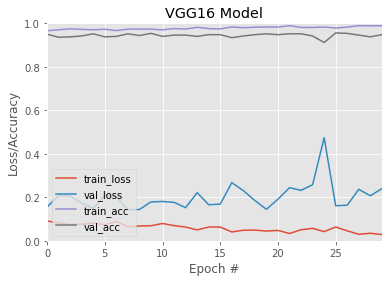

In [ ]:
VGG16_H = training(VGG16_model, 'VGG16', 'v1.0')

## ResNet50 model 

training the ResNet50 model
Epoch 1/30
125/125 [==============================] - 42s 338ms/step - loss: 0.0878 - accuracy: 0.9705 - val_loss: 3.9918 - val_accuracy: 0.5180
Epoch 2/30
125/125 [==============================] - 41s 329ms/step - loss: 0.0859 - accuracy: 0.9710 - val_loss: 1.8759 - val_accuracy: 0.5540
Epoch 3/30
125/125 [==============================] - 41s 328ms/step - loss: 0.0818 - accuracy: 0.9732 - val_loss: 0.2806 - val_accuracy: 0.9140
Epoch 4/30
125/125 [==============================] - 41s 328ms/step - loss: 0.0881 - accuracy: 0.9690 - val_loss: 0.2274 - val_accuracy: 0.9360
Epoch 5/30
125/125 [==============================] - 41s 328ms/step - loss: 0.0824 - accuracy: 0.9710 - val_loss: 0.6659 - val_accuracy: 0.8000
Epoch 6/30
125/125 [==============================] - 41s 329ms/step - loss: 0.0829 - accuracy: 0.9682 - val_loss: 0.2352 - val_accuracy: 0.9260
Epoch 7/30
125/125 [==============================] - 41s 327ms/step - loss: 0.0748 - accuracy: 0.9737

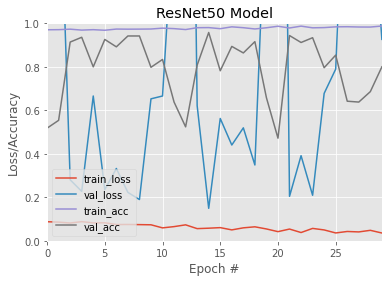

In [ ]:
ResNet50_H = training(ResNet50_model, 'ResNet50', 'v1.0')

## DenseNet121 model

training the DenseNet121 model
Epoch 1/30
125/125 [==============================] - 42s 339ms/step - loss: 0.0396 - accuracy: 0.9847 - val_loss: 0.2004 - val_accuracy: 0.9400
Epoch 2/30
125/125 [==============================] - 42s 332ms/step - loss: 0.0372 - accuracy: 0.9860 - val_loss: 0.2108 - val_accuracy: 0.9500
Epoch 3/30
125/125 [==============================] - 41s 329ms/step - loss: 0.0315 - accuracy: 0.9880 - val_loss: 5.5408 - val_accuracy: 0.4620
Epoch 4/30
125/125 [==============================] - 41s 329ms/step - loss: 0.0380 - accuracy: 0.9837 - val_loss: 0.7239 - val_accuracy: 0.8280
Epoch 5/30
125/125 [==============================] - 41s 330ms/step - loss: 0.0363 - accuracy: 0.9893 - val_loss: 1.1464 - val_accuracy: 0.6800
Epoch 6/30
125/125 [==============================] - 41s 330ms/step - loss: 0.0332 - accuracy: 0.9893 - val_loss: 0.6441 - val_accuracy: 0.8520
Epoch 7/30
125/125 [==============================] - 41s 329ms/step - loss: 0.0324 - accuracy: 0.9

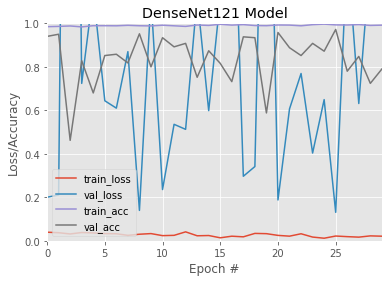

In [ ]:
DenseNet121_H = training(DenseNet121_model, 'DenseNet121', 'v1.0')

## InceptionV3 model

In [ ]:
InceptionV3_H = training(InceptionV3_model, 'InceptionV3', 'v1.0')

## Xception model

training the Xception model
Epoch 1/30
125/125 [==============================] - 50s 397ms/step - loss: 0.0103 - accuracy: 0.9967 - val_loss: 0.1335 - val_accuracy: 0.9720
Epoch 2/30
125/125 [==============================] - 50s 394ms/step - loss: 0.0101 - accuracy: 0.9967 - val_loss: 0.3286 - val_accuracy: 0.9440
Epoch 3/30
125/125 [==============================] - 50s 394ms/step - loss: 0.0071 - accuracy: 0.9973 - val_loss: 0.1595 - val_accuracy: 0.9660
Epoch 4/30
125/125 [==============================] - 50s 394ms/step - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.1667 - val_accuracy: 0.9700
Epoch 5/30
125/125 [==============================] - 50s 394ms/step - loss: 0.0099 - accuracy: 0.9967 - val_loss: 0.2321 - val_accuracy: 0.9580
Epoch 6/30
125/125 [==============================] - 50s 394ms/step - loss: 0.0077 - accuracy: 0.9977 - val_loss: 0.1510 - val_accuracy: 0.9740
Epoch 7/30
125/125 [==============================] - 50s 394ms/step - loss: 0.0143 - accuracy: 0.9940

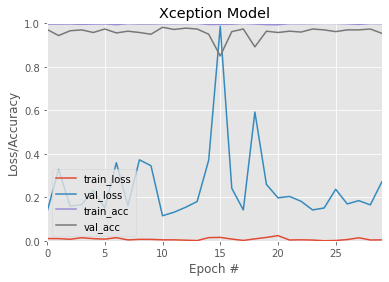

In [ ]:
Xception_H = training(Xception_model, 'Xception', 'v1.0')

# Eveluate

In [39]:
BS = 10

def evaluate(model, name, H):
  tic = time.time()


  # plot the training loss and accuracy
  N = EPOCHS
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
  plt.title(f'{name} Model')
  plt.xlabel("Epoch #")
  plt.axis([0, 30, 0, 1])
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")

  plt.savefig("/content/drive/MyDrive/Covid Thesis/images/{}.png".format(name))
  plt.show()

  # make predictions on the testing set
  print(f"[INFO] evaluating {name} model...")
  predIdxs = model.predict(test_data_gen, batch_size=BS)
  predIdxs = np.argmax(predIdxs, axis=1)

  true_classes = test_data_gen.classes
  class_labels = list(test_data_gen.class_indices.keys())  

  cf = classification_report(true_classes, predIdxs, target_names=class_labels)
  print(cf)

  # confusion matrix
  cm = confusion_matrix(true_classes, predIdxs) 
  df_cm = pd.DataFrame(cm, range(3), range(3), dtype='int32')
  plt.figure(figsize=(10,7))
  sn.set(font_scale=1.4)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=['Covid', 'Normal', 'Pneumonia'],  yticklabels=['Covid', 'Normal', 'Pneumonia'],  fmt='g', cmap='Blues')
  plt.title('Confusion Matrix')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.show()


  toc = time.time()
  print(f'Evaluation Runtime {(toc-tic)} Seconds')

  print('\n-----------------------------------------------------------\n')

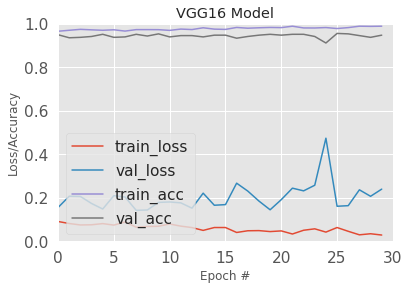

[INFO] evaluating VGG16 model...
              precision    recall  f1-score   support

       covid       0.18      0.19      0.18        70
      normal       0.40      0.40      0.40       215
   pneumonia       0.40      0.40      0.40       215

    accuracy                           0.37       500
   macro avg       0.33      0.33      0.33       500
weighted avg       0.37      0.37      0.37       500



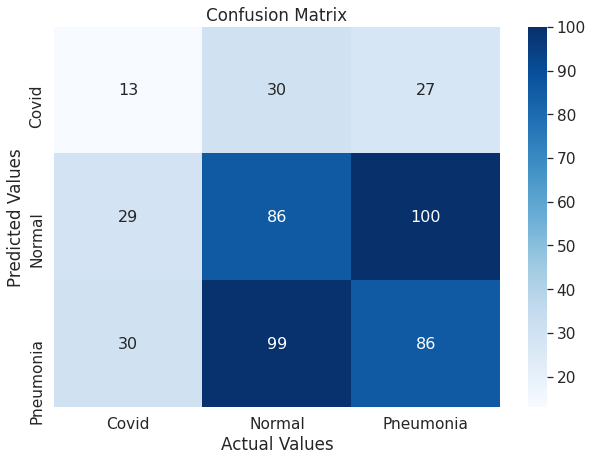

Evaluation Runtime 1.624598741531372 Seconds

-----------------------------------------------------------



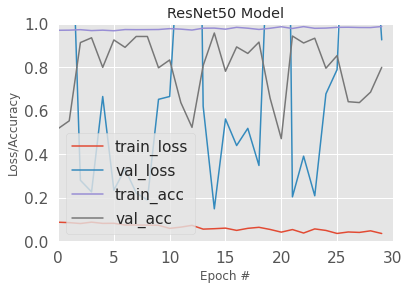

[INFO] evaluating ResNet50 model...
              precision    recall  f1-score   support

       covid       0.16      0.17      0.17        70
      normal       0.42      0.24      0.31       215
   pneumonia       0.43      0.60      0.50       215

    accuracy                           0.39       500
   macro avg       0.34      0.34      0.33       500
weighted avg       0.39      0.39      0.37       500



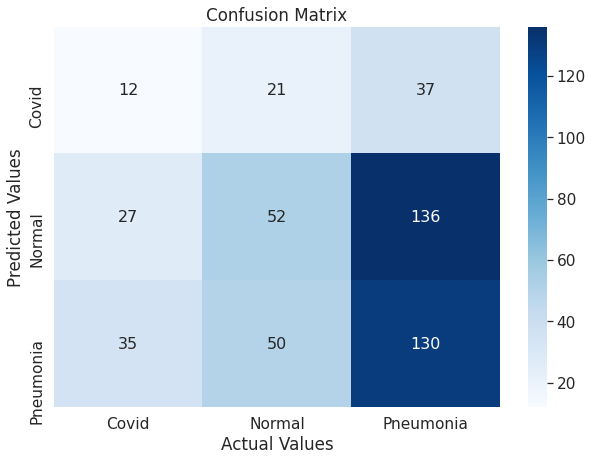

Evaluation Runtime 1.5326731204986572 Seconds

-----------------------------------------------------------



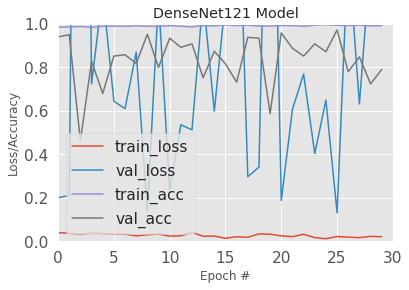

[INFO] evaluating DenseNet121 model...
              precision    recall  f1-score   support

       covid       0.15      0.10      0.12        70
      normal       0.41      0.62      0.50       215
   pneumonia       0.40      0.24      0.30       215

    accuracy                           0.39       500
   macro avg       0.32      0.32      0.31       500
weighted avg       0.37      0.39      0.36       500



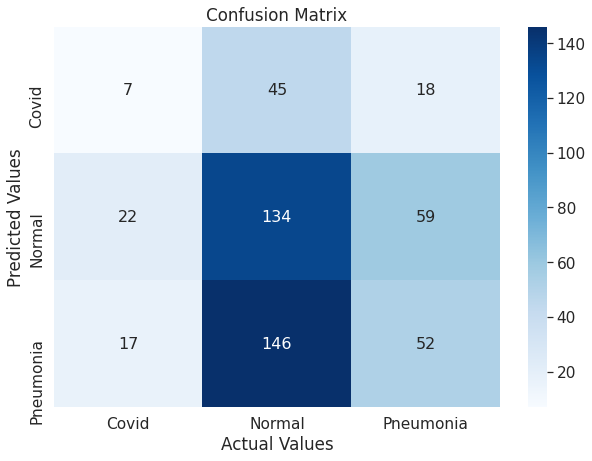

Evaluation Runtime 1.5501604080200195 Seconds

-----------------------------------------------------------



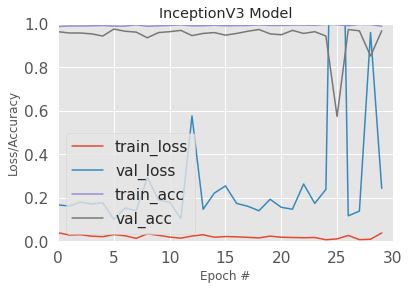

[INFO] evaluating InceptionV3 model...
              precision    recall  f1-score   support

       covid       0.17      0.17      0.17        70
      normal       0.39      0.37      0.38       215
   pneumonia       0.39      0.41      0.40       215

    accuracy                           0.36       500
   macro avg       0.32      0.32      0.32       500
weighted avg       0.36      0.36      0.36       500



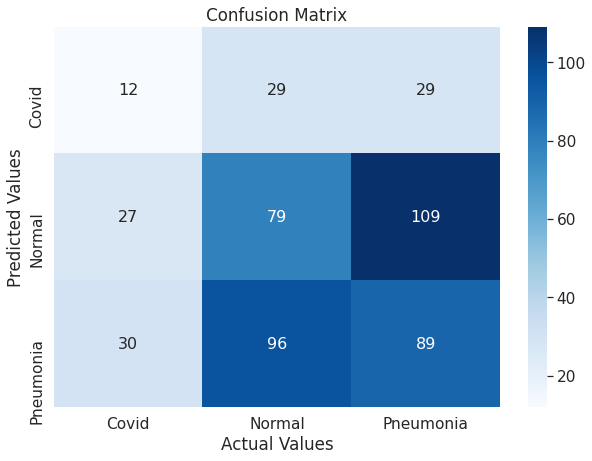

Evaluation Runtime 1.4854750633239746 Seconds

-----------------------------------------------------------



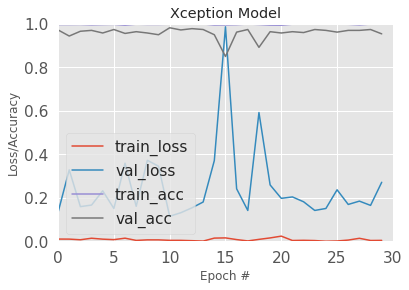

[INFO] evaluating Xception model...
              precision    recall  f1-score   support

       covid       0.15      0.14      0.14        70
      normal       0.42      0.47      0.44       215
   pneumonia       0.44      0.39      0.41       215

    accuracy                           0.39       500
   macro avg       0.34      0.33      0.33       500
weighted avg       0.39      0.39      0.39       500



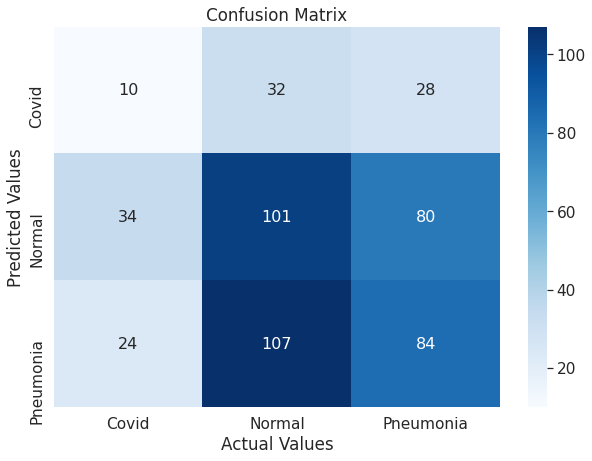

Evaluation Runtime 1.8084356784820557 Seconds

-----------------------------------------------------------



In [40]:
evaluate(VGG16_model, 'VGG16', VGG16_H)
evaluate(ResNet50_model, 'ResNet50', ResNet50_H)
evaluate(DenseNet121_model, 'DenseNet121', DenseNet121_H)
evaluate(InceptionV3_model, 'InceptionV3', InceptionV3_H)
evaluate(Xception_model, 'Xception', Xception_H)